In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Dense, LSTM, CuDNNLSTM, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, \
                                        accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [12]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

In [13]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

In [14]:
df = pd.read_csv('../data/alldata-balanced-cleaned.zip', compression='zip')
df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram,toxicity
0,144abb9156acc835,"""\nFor what it's worth, I suggest you refrain ...",0,0,0,0,0,0,for what it is worth i suggest you refrain fr...,"['for', 'what', 'it', 'is', 'worth', 'i', 'sug...","['worth', 'suggest', 'refrain', 'pushing', 'so...","['worth', 'suggest', 'refrain', 'push', 'sock'...","[('worth', 'JJ'), ('suggest', 'JJS'), ('refrai...","['worth', 'suggest', 'refrain', 'pushing', 'so...","['worth', 'suggest', 'refrain', 'push', 'sock'...","[('worth', 'suggest'), ('suggest', 'refrain'),...",0


In [15]:
df['comment_text'][0], df['clean_text'][0]

('"\nFor what it\'s worth, I suggest you refrain from pushing the ""socks"" remarks around, as it only seems to add fuel to the matter. Given that an SPI has been opened and Checkuser denied due to Stale accounts and behaviour evidence alone, it serves no purpose to accuse him further, just as it serves no purpose for him to accuse you of stalking. No one is going to win that type of argument. Also, I suggest you stop calling cowboy ""Jake"" from now on, as it also implies that he is someone he claims not to be. Clearly he is determined to push his case, and the only way to make it go away is that you ignore him altogether. Socks are a complex issue as they come in different forms. But if you give them enough rope, they\'ll eventually hang themselves with it. Challenging suspected socks non-stop is sometimes considered uncivil and may seem like a personal attack without confirmation. SPI does not support the claim at present, and baiting cowboy will not look good on your behalf, whatev

In [16]:
# Ci sono commenti che sono solo numeri
df['clean_text'] = df['clean_text'].apply(lambda x: str(x))

# Binary Task (toxic vs no_toxic)

In [28]:
text = df.clean_text.values
target = df.toxicity.values

#Parameters
n_classes=1
max_words=50000
max_sequence_length=200
embedding_dims = 50
hidden_units=16

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text) 
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

word_index = tokenizer.word_index
embeddings_index = load_embedding("../glove.6B.50d.txt")
#embeddings_index = load_embedding("./wiki.simple.vec")

X_train, X_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=100)

print(f'train sequences {len(X_train)}')
print(f'test sequences {len(X_test)}')
print(f'x_train shape: {X_train.shape}')
print(f'x_test shape: {X_test.shape}')

train sequences 35948
test sequences 8988
x_train shape: (35948, 200)
x_test shape: (8988, 200)


In [29]:
model = Sequential()
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dims))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model.add(Embedding(len(word_index) + 1,
                          embedding_dims,
                          weights=[embedding_matrix],
                          input_length=max_sequence_length,
                          trainable=True))

model.add(CuDNNLSTM(hidden_units))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', name='pre-classifier'))
model.add(Dense(n_classes, activation='sigmoid', name='classifier'))

In [30]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           4747950   
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 16)                4352      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 pre-classifier (Dense)      (None, 64)                1088      
                                                                 
 classifier (Dense)          (None, 1)                 65        
                                                                 
Total params: 4,753,455
Trainable params: 4,753,455
Non-trainable params: 0
_________________________________________________________________


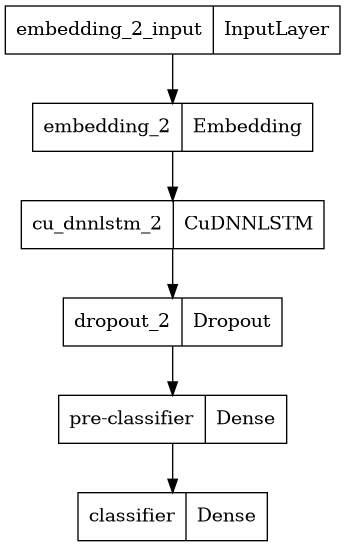

In [31]:
tf.keras.utils.plot_model(model)

In [32]:
epochs=20
batch_size=32

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
              validation_split=0.1,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[es])

Epoch 1/20
1012/1012 [==============================] - 13s 13ms/step - loss: 0.3752 - acc: 0.8426 - val_loss: 0.2634 - val_acc: 0.8896
Epoch 2/20
1012/1012 [==============================] - 13s 13ms/step - loss: 0.2437 - acc: 0.9086 - val_loss: 0.2522 - val_acc: 0.8951
Epoch 3/20
1012/1012 [==============================] - 13s 13ms/step - loss: 0.1874 - acc: 0.9303 - val_loss: 0.2385 - val_acc: 0.8965
Epoch 4/20
1012/1012 [==============================] - 13s 13ms/step - loss: 0.1466 - acc: 0.9468 - val_loss: 0.2534 - val_acc: 0.8974
Epoch 5/20
1012/1012 [==============================] - 13s 12ms/step - loss: 0.1114 - acc: 0.9615 - val_loss: 0.3108 - val_acc: 0.8926
Epoch 6/20
1012/1012 [==============================] - 13s 13ms/step - loss: 0.0852 - acc: 0.9714 - val_loss: 0.3663 - val_acc: 0.8798
Epoch 7/20
1012/1012 [==============================] - 13s 12ms/step - loss: 0.0674 - acc: 0.9780 - val_loss: 0.4101 - val_acc: 0.8901
Epoch 8/20
1012/1012 [==========================

In [36]:
history.history

{'loss': [0.3751772940158844,
  0.24369779229164124,
  0.18736803531646729,
  0.1465599536895752,
  0.11140795797109604,
  0.08522891253232956,
  0.06742904335260391,
  0.051237523555755615],
 'acc': [0.8426111936569214,
  0.9086019992828369,
  0.9302692413330078,
  0.9468055367469788,
  0.9614564180374146,
  0.9713782072067261,
  0.9779927730560303,
  0.9831854701042175],
 'val_loss': [0.2634388506412506,
  0.25215694308280945,
  0.23854511976242065,
  0.25338199734687805,
  0.31077152490615845,
  0.36626139283180237,
  0.4100551903247833,
  0.46527987718582153],
 'val_acc': [0.8895688652992249,
  0.8951321244239807,
  0.8965229392051697,
  0.8973574638366699,
  0.8926286697387695,
  0.8798331022262573,
  0.8901251554489136,
  0.8881780505180359]}

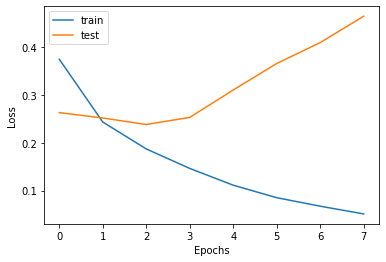

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

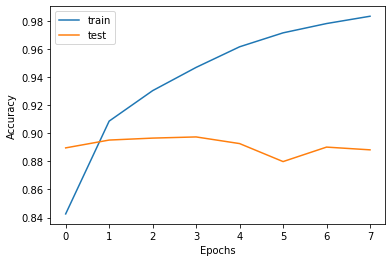

In [38]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
y_prob = model.predict(X_test)
y_pred = y_prob.round()

In [40]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4513
           1       0.89      0.90      0.90      4475

    accuracy                           0.90      8988
   macro avg       0.90      0.90      0.90      8988
weighted avg       0.90      0.90      0.90      8988



array([[4023,  490],
       [ 438, 4037]])

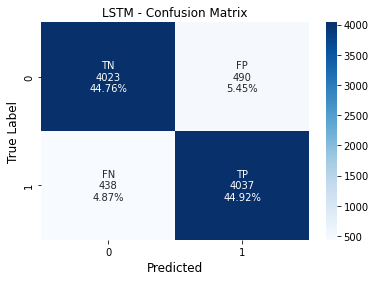

In [41]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'LSTM - Confusion Matrix')

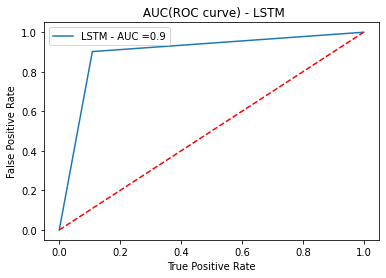

In [42]:
plot_roc_curve(y_test, y_pred, 'LSTM')